## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction: Prompt From Udacity

You will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Reading in Dataset

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Shape of Dataset

In [4]:
df.shape

(294478, 5)

> This output contians the total number of rows in that data set followed by the number of columns. This value is not yet ready for data anlysis because it may contain missing values in certain columns or may contain duplicates in the same column. The analysis will be most effective when only considering data that is present in all relevant columns with no duplications as outcomes will be inaccurate if certain characteristics are weighed inappropriately due to differing sample sizes.

Unique Users in Dataset

In [5]:
df['user_id'].nunique()

290584

The Proportion of Users Converted.

In [6]:
count_con = df.groupby('converted').nunique()['user_id'][1]
total = df['user_id'].nunique()
prop = count_con / total
print(prop)

0.121042452441


The Number of Times `new_page` and `treatment` are Mismatched

In [7]:
#mislabeled treatment
treat_err = df.query('landing_page == "new_page" and group != "treatment"')['user_id'].nunique()
#mislabeled control
contr_err = df.query('landing_page == "old_page" and group != "control"')['user_id'].nunique()
#total errors
print(treat_err + contr_err)

3893


Checking for Missing Values

In [8]:
#no missing rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


> The info() command presents a summary of the data frame and gives the maximum number of rows and the number of rows and data type for every column within the dataset. Since the maximum number of rows matches the number rows in each and every column, no datapoints are missing.

Dropping Mismatched Rows

In [9]:
error = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]
df2 = df.drop(labels = error.index) 

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Checking Unique Users in New Dataset

In [11]:
df2['user_id'].nunique()

290584

Dealing With Duplicate ID's

In [12]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

Duplicate ID Data

In [13]:
df2[df2.duplicated(['user_id'], keep = False)]
#Duplicate is caused by a patient with two different timestamps

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Dropping One Duplicate

In [14]:
df2.drop_duplicates(subset = 'user_id', inplace = True)

Probability of an Individual Converting Regardless of the Recieved Page

In [15]:
df2['converted'].mean()

0.11959708724499628

Probability of Conversion Given Group was "control"

In [16]:
pcon = df2.query('group == "control"')['converted'].mean()
pcon

0.1203863045004612

Probability of Conversion Given Group was "treatment"

In [17]:
ptreat = df2.query('group == "treatment"')['converted'].mean()
ptreat

0.11880806551510564

Probability of Individual Recieving Old/New Page

In [18]:
pd.get_dummies(df2['group'])['treatment'].mean()

0.50006194422266881

Preliminary Conclusions Based on Probabilities

> The measurements gathered in the previous parts are not sufficient evidence to conclude that the new treatment page leads to more conversions. The overall rate of conversion is 12%, which is almost identical to the rate of conversions given either a new page or old page. However, this does not speak anything about intertemporal changes that created the observed conversion rate. Is the new page actually more effective, but the experiment was held over a shorter time period? Or during a period when conversions are less popular? The old page is also subject to the same scrutiny. In general, aggregate observations dismiss much of the nuance, and a more meaningful statistic can come from including the duration column of the dataset.

<a id='ab_test'></a>
### Part II - A/B Test Through Hypothesis Tests


Hypothesis Test with a 5% Significance Level

**H0:** **$p_{old}$** $\ge$ **$p_{new}$**

**H1:** **$p_{old}$** $\lt$ **$p_{new}$**

Conversion Rate for $p_{new}$ Under the Null 

In [19]:
c_rate = df2['converted'].mean()
c_rate

0.11959708724499628

Conversion Rate for $p_{old}$ Under the Null 

In [20]:
c_rate

0.11959708724499628

Number of Individuals in the Treatment Group: $n_{new}$

In [21]:
n_new = df2.groupby('group').count()['user_id']['treatment']
n_new

145310

Number of Individuals in the Control Group: $n_{old}$

In [22]:
n_old = df2.groupby('group').count()['user_id']['control']
n_old

145274

Simulation of $n_{new}$ Transactions with a Conversion Rate of $p_{new}$ Under the Null

In [23]:
new_page_converted = np.random.binomial(1, c_rate, n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Simulation of $n_{old}$ Transactions with a Conversion Rate of $p_{old}$ Under the Null

In [24]:
old_page_converted = np.random.binomial(1, c_rate, n_old)
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

$p_{new}$ - $p_{old}$ for Simulated Values

In [25]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.00044249682677896529

#### Simulating Diffs Over 10,000 Iterations

In [26]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.binomial(1, c_rate, n_new)
    old_page_converted = np.random.binomial(1, c_rate, n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

#### Plotting Diffs 

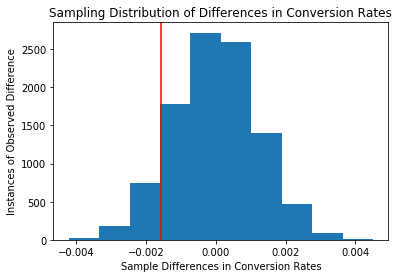

In [27]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.xlabel('Sample Differences in Conversion Rates')
plt.ylabel('Instances of Observed Difference')
plt.title('Sampling Distribution of Differences in Conversion Rates')
ab_diff = ptreat - pcon
plt.axvline(ab_diff, color = 'r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
list((p_diffs > ab_diff)).count(True) / len(p_diffs)

0.9023

##### P-Value Discussion

> This value is an approximation of the p-value, with the p-value defined as the probability of observing a statistic in favor of the alternate hypothesis, given that the null hypothesis is true. In this case, the null hypothesis is defined as a difference in conversion that is less than or equal to zero, while the alternate hypothesis is a difference in connversion that is positive. In this approximation, the p-value is roughly 90%; 90% of the sampling distribution that assumes the null hypothesis to be true is greater than the observed sample statistic. Since the p-value is larger than the significance level of .05, or the highest probability of Type I error we are willing to accept, we fail to reject the null hypothesis.

### Calculating Z-Stat and P-Value with Built-in Functions

In [29]:
df2.query('group == "control"')['converted'].sum()/df2.query('group == "control"').shape[0]

0.1203863045004612

In [30]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Z-Statistic and P-value From Statsmodel

In [31]:
zstat, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], value = 0, alternative = 'smaller')
#smaller one-sided test used because alt hypothesis supposes old p to be less than new p
print('The test statistic is {} and the p-value is {}'.format(zstat, pval))

The test statistic is 1.3109241984234394 and the p-value is 0.9050583127590245


##### P-Value Discussion

>Since the test statistic is small (less than 1.64) and the p-value (greater than .05)is very large, we fail to reject the null hypothesis. The computed test statistic and p-value match the earlier findings in parts j and k. These findings provide evidence that the new web page does not signficantly encourage more conversions.

<a id='regression'></a>
### Part III - A regression approach


> Logistic Regression is used because there are only two possible outcomes, converted or not converted.

In [32]:
df2['intercept'] = 1
df2 = df2.join(pd.get_dummies(df2['group']))
df2['ab_page'] = df2['treatment']

In [33]:
y = df2[['converted']]
X = df2[['intercept', 'ab_page']]

In [34]:
model = sm.Logit(y, X)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 03 Aug 2019   Pseudo R-squ.:               8.077e-06
Time:                        05:34:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

##### ab_page P-value Discussion

> The p-value of ab_page is .19, and differs from the value found in part II because the p-value found in part II was based on a null hypothesis that the rate of conversions from the old page were the same or greater than the rate of conversions from the new page. Therefore, the null hypothesis corresponds to a one-tailed test which sets the significance value to 0.05. Meanwhile, the the null hypothesis of the logistic regression is a question of relationship between X and Y, or B1 = 0. Since this hypothesis test is a matter of equating, this makes this a two-tailed test and sets the significance value at 0.0025; this is because extreme values may be found on either end of the distribution. 

> In all, the p-value is still larger than the a significance level, and thus we fail to reject the null hypothesis; at least, it does not seem to appear that a new page explains the variability in conversion rates. Interestingly enough, this seems to align with the initial findings, where the conversion rates of either the old page and the new page were the same as the universal rate of conversions, which might suggest that the likelihood to convert is unrelated to the design of the page.

### Discussion on Adding/Removing Variables

> Adding more factors may determine a better fitting model, and provide information on relevant areas of improvement. For instance, including an age or profession column may help determine the design of the next new page, perhaps catering to the largest demographic or retaining a typically neglected one.

>On the flipside, adding more factors will obfuscate the value of each individual factor, and increase multicollinearity. In the case of too many added factors, it will become difficult to determine the factor that is the greatest contributor to the conversions.

### Impact of Country on Conversion

In [36]:
countries = pd.read_csv('countries.csv')
df3 = countries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')

In [37]:
df3 = df3.join(pd.get_dummies(df3['country']))

In [38]:
y = df3[['converted']]
X = df3[['intercept', 'UK', 'CA']]
#US as base

In [39]:
model = sm.Logit(y, X)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 03 Aug 2019   Pseudo R-squ.:               1.521e-05
Time:                        05:34:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

> Based on the large p-values of .456 and .129, it does not appear that either the UK or CA is statistically signifcant in explaining the variability conversions. Although the intercept represents the US, it cannot is not readily interpreted. As it stands, it does not appear the countries is a statistically significant factor in explaining conversions.

### Interaction Between Page and Country on Conversions

In [47]:
#creating interaction columns
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']
df3['CA_ab_page'] = df3['CA'] * df3['ab_page']

In [48]:
y = df3[['converted']]
X = df3[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']]
#control as base, US as base

In [49]:
model = sm.Logit(y, X)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 03 Aug 2019   Pseudo R-squ.:               3.482e-05
Time:                        05:35:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

### P-Value Discussion and Analysis Results

> In this analysis the none of the variables demonstrate p-values that are above the significance level of 0.05 of a two tailed-test, and therefore do not seem to have a relation with conversion rates and are not statistically insignifcant. As a whole, we fail to reject the null hypothesis that a new page design, country, or an interaction between design and country explain the variation in conversion rates.

### Conclusion

> Overall, this analysis and dataset does not offer conclusive evidence on characteristics that explain the variability in conversion rates. Nonetheless, despite the lack of concrete relationships, valuable and suprising observations are still gleaned from this dataset. For instance, a lack of apparent relationship between aesthetic design, nationality (Western), and conversion rates has implications for budget allocations. For example, although a basic level of aesthetics and localization is most likely required for site accesability, investing further is unlikely to net better results.

> All in all, although no concrete relationship was deemed significant, one might conclude that conversion rates are dependent on an unobservable or unmeasured characteristic, and not explainable by our avaliable data; this is, of course, contingent on the fact that those who convert have quantifiable and observable characteristics that are non-random.

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0